# Plesio-Geostrophy Model - Spectral Expansions

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import special as specfun
import matplotlib.pyplot as plt

from pg_utils.pg_model import base, core

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
print(core.B_vec.__doc__)

Vector in 3D
    


## Regularity conditions

In [3]:
x_array = np.linspace(-1, 1, num=100)
y_array = np.linspace(-1, 1, num=100)
X, Y = np.meshgrid(x_array, y_array)

s_array = np.linspace(0, 1, num=100)
p_array = np.linspace(-np.pi, +np.pi, num=100)

S = np.sqrt(X**2 + Y**2)
Phi = np.arctan2(Y, X)
CPhi = np.cos(Phi)
SPhi = np.sin(Phi)

### Scalar field

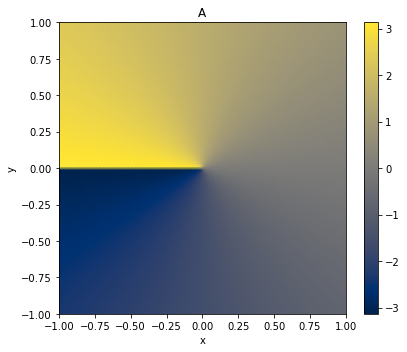

In [32]:
A = Phi

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

cm = ax.pcolormesh(X, Y, A, shading="gouraud", cmap="cividis")
plt.colorbar(cm, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("A")

plt.tight_layout()
plt.show()

### Vector field

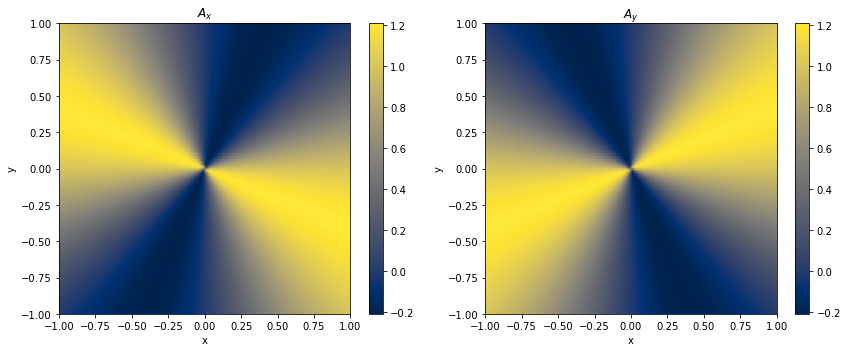

In [31]:
# As = CPhi
# Ap = SPhi
As = np.real(1*np.exp(1j*1*Phi))
Ap = np.real(1*np.exp(1j*1*Phi))

Ax = CPhi*As - SPhi*Ap
Ay = SPhi*As + CPhi*Ap

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax = axes[0]
cm = ax.pcolormesh(X, Y, Ax, shading="gouraud", cmap="cividis")
plt.colorbar(cm, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(r"$A_x$")

ax = axes[1]
cm = ax.pcolormesh(X, Y, Ay, shading="gouraud", cmap="cividis")
plt.colorbar(cm, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(r"$A_y$")

plt.tight_layout()
# plt.savefig("./presentation/elements/singular_field.png", format="png", dpi=150, bbox_inches="tight")
plt.show()

### Rank-2 tensor field

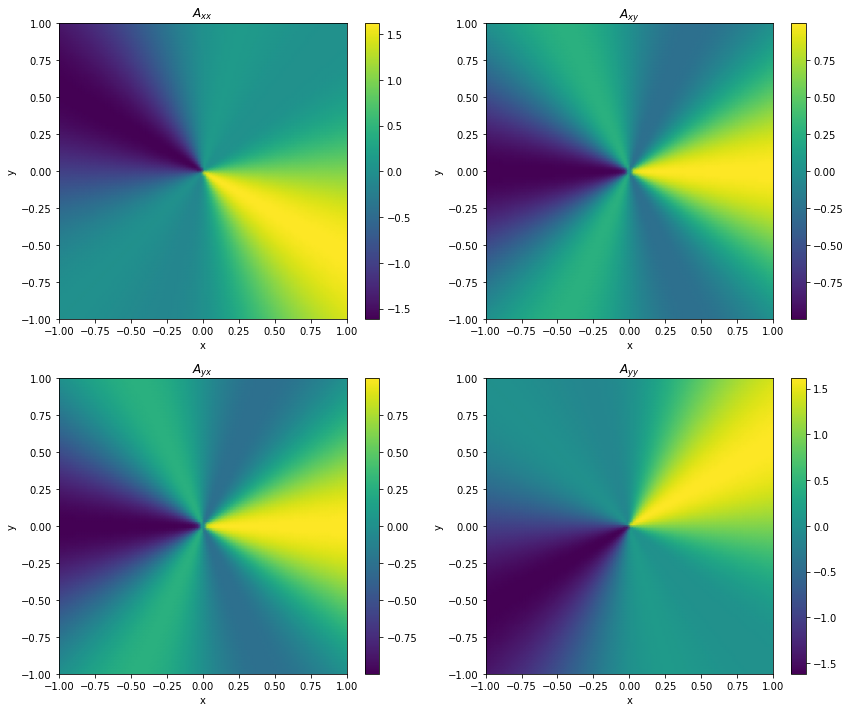

In [27]:
Ass = np.real(1*np.exp(1j*1*Phi))
App = np.real(1*np.exp(1j*1*Phi))
Asp = np.real(1*np.exp(1j*1*Phi))
Aps = np.real(1*np.exp(1j*1*Phi))

Axx = CPhi**2*Ass + SPhi**2*App - SPhi*CPhi*(Asp + Aps)
Ayy = SPhi**2*Ass + CPhi**2*App + SPhi*CPhi*(Asp + Aps)
Axy = SPhi*CPhi*(Ass - App) + CPhi**2*Asp - SPhi**2*Aps
Ayx = SPhi*CPhi*(Ass - App) + CPhi**2*Aps - SPhi**2*Asp

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

ax = axes[0, 0]
cm = ax.pcolormesh(X, Y, Axx, shading="gouraud")
plt.colorbar(cm, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(r"$A_{xx}$")

ax = axes[0, 1]
cm = ax.pcolormesh(X, Y, Axy, shading="gouraud")
plt.colorbar(cm, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(r"$A_{xy}$")

ax = axes[1, 0]
cm = ax.pcolormesh(X, Y, Ayx, shading="gouraud")
plt.colorbar(cm, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(r"$A_{yx}$")

ax = axes[1, 1]
cm = ax.pcolormesh(X, Y, Ayy, shading="gouraud")
plt.colorbar(cm, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(r"$A_{yy}$")


plt.tight_layout()
# plt.savefig("./presentation/elements/singular_field.png", format="png", dpi=150, bbox_inches="tight")
plt.show()

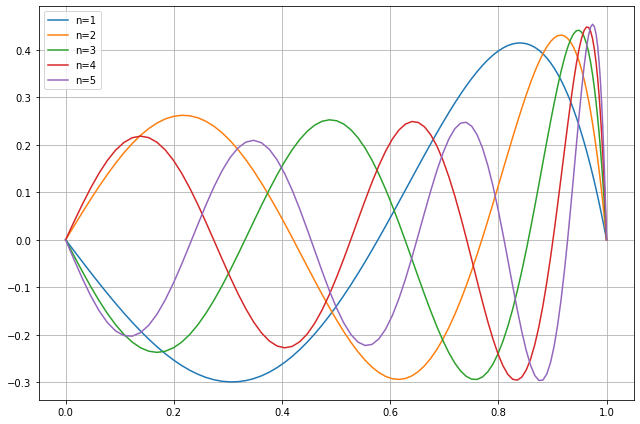

In [2]:
m_mode = 2

alpha = 2
beta = m_mode - 3/2
leading_power = np.abs(np.abs(m_mode) - 1)
n_array = np.arange(1, 6)

xi, _ = specfun.roots_jacobi(100, alpha, beta)
xi = np.r_[-1, xi, 1]
s = np.sqrt((1 + xi)/2)

basis_array = np.zeros((n_array.size, s.size))
for i, n in enumerate(n_array):
    basis_array[i, :] = specfun.jacobi(n, alpha, beta)(2*s**2 - 1)
s_basis_array = s**leading_power*(1 - s**2)*basis_array

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.0, 6.0), layout="tight")

# ax = axes[0]
# for i, n in enumerate(n_array):
#     ax.plot(s, basis_array[i], label="n={:d}".format(n))
# ax.legend()
# ax.grid()

for i, n in enumerate(n_array):
    ax.plot(s, s_basis_array[i], label="n={:d}".format(n))
ax.legend()
ax.grid()

plt.show()

In [3]:
import sympy
from sympy import diff

In [4]:
with open("./out/cases/Malkus/CG_Eqs_ptb.json", 'r') as fread:
    eqs_cg = base.CollectionConjugate.load_json(fread, parser=sympy.parse_expr)

In [9]:
eqs_cg.M_1

Eq(Derivative(\overline{m_1}(s, \phi, t), t), -4*s*Derivative(\psi(s, \phi, t), \phi, s))

In [7]:
with open("./out/cases/Malkus/Eqs_ptb.json", 'r') as fread:
    eqs_pg = base.CollectionPG.load_json(fread, parser=sympy.parse_expr)

In [8]:
eqs_pg.Psi

Eq(s**2*Derivative(\psi(s, \phi, t), s, t)/H(s)**3 + s*Derivative(\psi(s, \phi, t), (s, 2), t)/H(s) + s*Derivative(\psi(s, \phi, t), (\phi, 2), t)/(2*H(s)**3) + Derivative(\psi(s, \phi, t), s, t)/H(s) + Derivative(\psi(s, \phi, t), (\phi, 2), t)/(s*H(s)), -s**4*b_s^+(s, \phi, t)/(2*H(s)**4) - s**4*b_s^-(s, \phi, t)/(2*H(s)**4) - s**3*Derivative(b_s^+(s, \phi, t), s)/(2*H(s)**2) - s**3*Derivative(b_s^-(s, \phi, t), s)/(2*H(s)**2) - s**2*Derivative(b_z^+(s, \phi, t), s)/(2*H(s)) + s**2*Derivative(b_z^-(s, \phi, t), s)/(2*H(s)) - 3*s**2*b_s^+(s, \phi, t)/(2*H(s)**2) - 3*s**2*b_s^-(s, \phi, t)/(2*H(s)**2) - 2*s**2*b_{es}(s, \phi, t)/H(s)**2 - s**2*Derivative(b_{e\phi}(s, \phi, t), \phi)/H(s)**2 - s*b_z^+(s, \phi, t)/H(s) + s*b_z^-(s, \phi, t)/H(s) - s*Derivative(\overline{m_{s\phi}}(s, \phi, t), (s, 2))/(2*H(s)) - s*Derivative(\widetilde{m_{sz}}(s, \phi, t), \phi, s)/(2*H(s)**2) - 3*Derivative(\overline{m_{s\phi}}(s, \phi, t), s)/(2*H(s)) - Derivative(\overline{m_{\phi\phi}}(s, \phi, t), \

In [4]:
with open("./out/cases/Malkus/Eqs_reduced.json", 'r') as fread:
    eqs_reduced = base.LabeledCollection.load_json(fread, parser=sympy.parse_expr)

In [5]:
eqs_reduced.Psi

Eq(s**2*Derivative(\psi(s, \phi, t), s, t)/H(s)**3 + s*Derivative(\psi(s, \phi, t), (s, 2), t)/H(s) + s*Derivative(\psi(s, \phi, t), (\phi, 2), t)/(2*H(s)**3) + Derivative(\psi(s, \phi, t), s, t)/H(s) + Derivative(\psi(s, \phi, t), (\phi, 2), t)/(s*H(s)), F_\mathrm{ext}(s, \phi, t) + 2*s*Derivative(\psi(s, \phi, t), \phi)/(\mathrm{Le}*H(s)**3))

In [15]:
eqs_reduced.F_ext

Eq(Derivative(F_\mathrm{ext}(s, \phi, t), t), s**2*Derivative(\psi(s, \phi, t), (\phi, 2), s)/H(s)**3 + s*Derivative(\psi(s, \phi, t), (\phi, 2), (s, 2))/H(s) - 2*s*Derivative(\psi(s, \phi, t), (\phi, 2))/H(s)**3 + s*Derivative(\psi(s, \phi, t), (\phi, 4))/(2*H(s)**3) + Derivative(\psi(s, \phi, t), (\phi, 2), s)/H(s) + Derivative(\psi(s, \phi, t), (\phi, 4))/(s*H(s)))